# Car Price Prediction

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [13]:
df = pd.read_csv("./car_price_dataset.csv")
# Note - Mileage => How many km has the car travelled

In [14]:
df.isnull().sum().sum()

0

In [15]:
df.head(5)

df.apply(lambda x: x.unique(), axis=0)

Brand           [Kia, Chevrolet, Mercedes, Audi, Volkswagen, T...
Model           [Rio, Malibu, GLA, Q5, Golf, Camry, Civic, Spo...
Year            [2020, 2012, 2023, 2003, 2007, 2010, 2001, 201...
Engine_Size     [4.2, 2.0, 2.6, 2.7, 3.4, 4.7, 3.1, 1.3, 4.5, ...
Fuel_Type                      [Diesel, Hybrid, Electric, Petrol]
Transmission                  [Manual, Automatic, Semi-Automatic]
Mileage         [289944, 5356, 231440, 160971, 286618, 157889,...
Doors                                                [3, 2, 4, 5]
Owner_Count                                       [5, 3, 2, 1, 4]
Price           [8501, 12092, 11171, 11780, 2867, 7242, 11208,...
dtype: object

In [16]:
# All data types are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


In [17]:
# df["Year"] = df["Year"].values
# df["Year"] = df["Year"].to_numpy() - 2000

In [18]:
df["Year"]

0       2020
1       2012
2       2020
3       2023
4       2003
        ... 
9995    2004
9996    2002
9997    2010
9998    2002
9999    2001
Name: Year, Length: 10000, dtype: int64

In [19]:
y = df["Price"]
X = df.drop(["Price"], axis=1)

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4)
print("Training data", X_train.shape, y_train.shape)

X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5)
print("Cross Validation: ", X_cv.shape, y_cv.shape, "\nTest Data: ", X_test.shape, y_test.shape)

Training data (6000, 9) (6000,)
Cross Validation:  (2000, 9) (2000,) 
Test Data:  (2000, 9) (2000,)


In [20]:
label_encoding_cols = ["Model", "Fuel_Type", "Transmission", "Brand"] # Label encoding for XGBoost

In [21]:
encoders: dict[str, 'LabelEncoder'] = {}

for item in label_encoding_cols:
    encoder = LabelEncoder()
    series = X_train[item]
    encoder.fit(series)

    X_train[item] = encoder.transform(X_train[item])
    X_cv[item] = encoder.transform(X_cv[item])
    X_test[item] = encoder.transform(X_test[item])

    encoders[item] = encoder

X_train

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count
1138,2,18,2009,3.1,0,1,137931,5,5
7945,0,2,2016,2.2,2,0,284193,2,4
3845,0,2,2007,3.3,3,1,284333,3,4
3172,4,4,2020,2.9,3,2,125825,3,5
210,5,11,2000,1.8,3,1,161487,3,5
...,...,...,...,...,...,...,...,...,...
5418,6,24,2004,2.1,1,1,218620,4,4
3563,9,17,2013,2.8,1,0,88109,5,3
1127,9,17,2004,3.0,0,1,265576,3,1
4204,9,27,2007,4.0,3,1,167913,5,5


In [22]:
# for item in label_encoding_cols:
#     encoder = encoders[item]
#     X_train[item] = encoder.inverse_transform(X_train[item])

# X_train

In [23]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

In [24]:
scalar.fit(X_train["Mileage"].values.reshape(-1, 1))

X_train["Mileage"] = scalar.transform(X_train["Mileage"].values.reshape(-1, 1))
X_cv["Mileage"] = scalar.transform(X_cv["Mileage"].values.reshape(-1, 1))
X_test["Mileage"] = scalar.transform(X_test["Mileage"].values.reshape(-1, 1))

In [25]:
print(f"Min value: {X_train["Mileage"].min():0.2f}, Max Value: {X_train["Mileage"].max():0.2f}")
print(f"Mean: {X_train["Mileage"].mean():0.2f}")

Min value: -1.72, Max Value: 1.75
Mean: -0.00


In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score

In [27]:
d_train = xgb.DMatrix(X_train.values, label=y_train.values) # Converting to DMatrix for faster calculation
d_cv = xgb.DMatrix(X_cv.values, label=y_cv.values) # Converting to DMatrix for faster calculation
d_test = xgb.DMatrix(X_test.values, label=y_test.values) # Converting to DMatrix for faster calculation


### Training

In [28]:
params = {
    "objective": "reg:squarederror",  # Regression objective
    "eval_metric": "rmse",
    "learning_rate": 0.06,
    "max_depth": 2,
    "alpha": 3,
    "lambda": 4
}

In [29]:
evals_result = {}

model = xgb.train(
    params=params, 
    dtrain=d_train, 
    num_boost_round=2500, 
    evals=[(d_train, "train"), (d_test, "test")], 
    evals_result=evals_result,  # ✅ Store loss values
    early_stopping_rounds=100,
)

[0]	train-rmse:3005.54361	test-rmse:3023.15186
[1]	train-rmse:2911.47202	test-rmse:2928.93095
[2]	train-rmse:2824.21422	test-rmse:2840.11789
[3]	train-rmse:2744.52999	test-rmse:2761.00221
[4]	train-rmse:2669.32918	test-rmse:2684.43017
[5]	train-rmse:2599.92839	test-rmse:2615.30286
[6]	train-rmse:2535.33176	test-rmse:2550.85230
[7]	train-rmse:2475.43161	test-rmse:2488.85941
[8]	train-rmse:2419.01055	test-rmse:2432.15872
[9]	train-rmse:2364.72709	test-rmse:2376.77302
[10]	train-rmse:2313.95367	test-rmse:2326.78038
[11]	train-rmse:2265.41560	test-rmse:2277.89881
[12]	train-rmse:2219.09353	test-rmse:2229.81532
[13]	train-rmse:2175.11558	test-rmse:2184.74708
[14]	train-rmse:2133.14359	test-rmse:2142.52003
[15]	train-rmse:2092.33439	test-rmse:2103.11982
[16]	train-rmse:2053.75676	test-rmse:2064.22472
[17]	train-rmse:2016.29550	test-rmse:2024.44209
[18]	train-rmse:1980.40967	test-rmse:1989.20905
[19]	train-rmse:1945.33848	test-rmse:1956.71790
[20]	train-rmse:1912.28507	test-rmse:1924.07281
[2

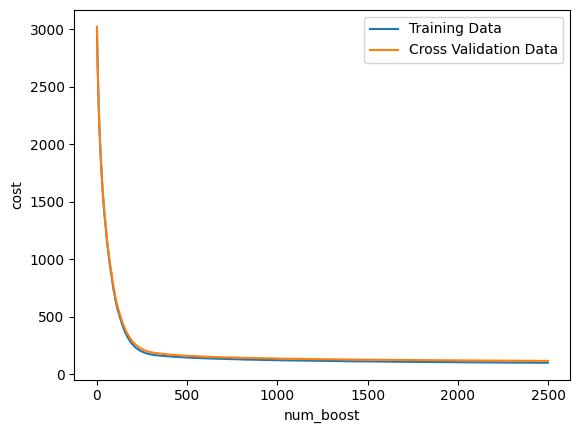

In [30]:
plt.plot(evals_result["train"]["rmse"])
plt.plot(evals_result["test"]["rmse"])
plt.legend(["Training Data", "Cross Validation Data"])
plt.xlabel("num_boost")
plt.ylabel("cost")
plt.show()

In [31]:
pred = model.predict(d_test)
print(mean_squared_error(y_test, pred))

13350.1181640625


In [32]:
model.get_score(importance_type="weight")

{'f0': 58.0,
 'f1': 126.0,
 'f2': 2117.0,
 'f3': 1587.0,
 'f4': 656.0,
 'f5': 214.0,
 'f6': 2662.0,
 'f7': 38.0,
 'f8': 42.0}

In [33]:
diff = list(zip(y_test, pred))

In [34]:
# y_train[lambda x: x < 5000]

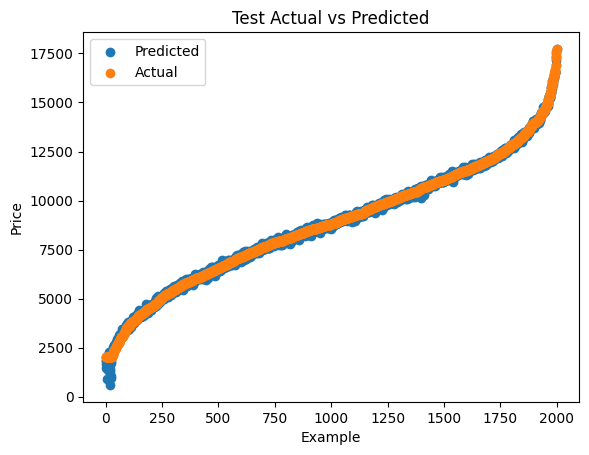

79.98084875488281

In [35]:
plot = np.array(list(sorted(diff, key=lambda x: x[0])))

plt.scatter(np.arange(y_test.shape[0]), plot[:, 1])
plt.scatter(np.arange(y_test.shape[0]), plot[:, 0])
plt.xlabel("Example")
plt.ylabel("Price")
plt.legend(["Predicted", "Actual"])
plt.title("Test Actual vs Predicted")
plt.show()

MAE = np.mean(np.abs(y_test - pred))
MAE

### K-FOLD Analysis

In [36]:
from sklearn.model_selection import KFold
import xgboost as xgb
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
mae_scores = []

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=100,
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(np.mean((preds - y_val) ** 2))
    mae = np.mean(np.abs(preds - y_val))

    rmse_scores.append(rmse)
    mae_scores.append(mae)

print(f"Avg RMSE: {np.mean(rmse_scores):.4f}")
print(f"Avg MAE: {np.mean(mae_scores):.4f}")


Avg RMSE: 119.4144
Avg MAE: 83.6066


In [37]:
# import pickle as pkl

# for item in label_encoding_cols:
#     with open(f"{item}.pkl", "wb") as file:
#         pkl.dump(encoders[item], file)

In [38]:
# with open("Mileage_Scalar.pkl", "wb") as file:
#     pkl.dump(scalar, file)

In [39]:
# with open("XGBModel.pkl", "wb") as file:
#     pkl.dump(model, file)